# Identify Factors that Predict Intro CS Experience Based on Gender


## Problem Statement

With this project, the problem I am interested in investigating is the gendered experience of the two CS classes in the study. Using machine learning algorithms, I want to identify the leading indicators of the experience broken down by gender in introductory CS at an elite research university like Berkeley. Basically I want to find the attributes that split the dataset as *purely* as possible into male and female.

To solve this problem, I will undertake the following course of action:
1. Explore the dataset
    - Usually, I would explore the dataset to ensure its integrity and understand the context. But in this case, I will skip this step since I designed the study and collected the data, as such, I am well versed of the context. Further, I have done previous work on this dataset, so I know its boundaries.
2. Identify features that may be used. 
    - If possible, engineer features that might provide greater discrimination.
3. With the understanding that this a `classification` task, explore a couple of classifiers that might be well suited for the problem at hand.
    - Random Forest classifier
    - eXtreme Gradient Boosted (XGBoost) trees classifier
    - Support Vector Machine (SVM)
    - Decision Tree classifier
4. Once a classifier has been selected, tune it for optimality.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import libraries
from __future__ import division
import sys
sys.path.append('tools/')

import numpy as np
import pandas as pd
import pickle
import tools

   
# Graphing Libraries
import matplotlib.pyplot as pyplt
import seaborn as sns
sns.set_style("white")    

### Explore the dataset

Let's go ahead and read in the student dataset. There are two functions that support this dataset:
- `dataLookUp(surveyItemCode)` This function take a string that is coded survey item. For example if you execute `dataLookUp(atcs_1)`, it prints out the corresponding survey question, I like to use computer science to solve problems. 
- `dataDescr()` This function gives you a general introduction to the dataset.

Note: Majority of the questionnaire uses a 5-point Likert scale (where 1 = Strongly Disagree, 3 = Neutral and 5 = Strongly Agree).

In [3]:
dataset = tools.preprocess()

In [4]:
tools.dataDescr()

UC Berkeley Intro CS Student dataset

Notes
------
Data Set Characteristics:

Number of Instances:882

Attribute Information:

Self reported attitudes about CS
- atcs_1 I like to use computer science to solve problems.
- atcs_2 I can learn to understand computing concepts.
- atcs_3 I can achieve good grades (C or better) in computing courses.
- atcs_4 I do not like using computer science to solve problems.
- atcs_5 I am confident that I can solve problems by using computation.
- atcs_6 The challenge of solving problems using computer science appeals to me.
- atcs_7 I am comfortable with learning computing concepts.
- atcs_8 I am confident about my abilities with regards to computer science.
- atcs_9 I do think I can learn to understand computing concepts.

Gendered belief about CS ability
- atcsgender_1 Women are less capable of success in CS than men.
- atcsgender_2 Women are smarter than men.
- atcsgender_3 Men have better math and science abilities than women.

Career driven beliefs

In [5]:
dataset = dataset.query('gender == "Female" or gender == "Male"') #load rows with binary gender
dataset = dataset.reset_index(drop=True)


print '{:d}{:20}{:d}{:20}'.format(len(dataset.query('gender == "Male"')), ' male students, and ',
                                  len(dataset.query('gender == "Female"')),
                                  ' female students consented to participate in this study')
                        

494 male students, and 388 female students consented to participate in this study


## Preprocess Data

### Preprocess feature columns
To prepare the data for classification, I need to devise a scheme to transform all features into numeric data. This dataset as several non-numeric columns that need converting. Many of them are simply `yes`/`no`, e.g. `prcs_2`. I can reasonably convert these into `1`/`0` (binary) values. For the columns whose values are `Nan`, I will convert these to `-1`. 

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['Yes', 'No'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            # e.g. 'reason' => 'reason_class_Interested' , 'reason_class_Other'
            col_data = pd.get_dummies(col_data, prefix=col)

        outX = outX.join(col_data)  # collect column(s) in output dataframe
        outX.fillna(-1, inplace=True) # make sure all NaN <missing> values are set to 0

    return outX



In [7]:
dataset = preprocess_features(dataset)
print "Processed feature columns ({}):- {}".format(len(dataset.columns), list(dataset.columns))


Processed feature columns (47):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'gender_Female', 'gender_Male', 'grade_B or above', 'grade_B or below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


### Preprocess feature columns - Rename columns

There are some columns that have whitespaces in their names, these makes it difficult for the tree plotting algorithms that we will be using later to graph these features. As a result, we will change these whitespaces to hypens.

In [8]:
dataset.rename(columns = {'grade_B or above':'grade_B_or_above'}, inplace = True)
dataset.rename(columns = {'grade_B or below':'grade_B_or_below'}, inplace = True)

### Scaling
Linearly scale each attribute to the range [0, 1] to get better output from the SVM.



In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
dataset = df_scaled
dataset.tail()


,atcs_1,atcs_2,atcs_3,atcs_4,atcs_5,atcs_6,atcs_7,atcs_8,atcs_9,atcsgender_1,...,mtr_3,prcs_1,prcs_2,prcs_3,prcs_4,prcs_5,prepared,priorcs10,reason_class_Interested,reason_class_Other
877,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.5,1.0,0.0
878,0.00,0.50,0.25,1.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.0,1.0
879,1.00,1.00,1.00,0.25,0.75,1.00,1.00,0.75,1.00,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.00,0.5,0.0,0.0
880,1.00,1.00,0.75,0.25,0.50,0.75,0.50,0.50,0.75,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.5,1.0,0.0
881,0.75,0.75,0.50,0.25,0.25,1.00,0.75,0.50,1.00,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.5,1.0,0.0


### Frequency Distribution

Create the dimension that I am interested in investigating.

- The role of mentorship: `mtr`
- The role of prior CS exposure: `prcs`
- The role of self reported attitude about CS competency: `atcs`
- The role of self reported attitudes about computational thinking: `atct`
- The role of self reported belonging in the class room: `blg`
- The role of social implications and ethics: `clet`
- The role of gendered notions of intelligence: `atcsgender`
- The role of career driven beliefs about CS: `atcsjob`
- The role of culutral competency: `cltrcmp`
- The role of CS10: `priorcs10`

In [10]:
mtr = ['mtr_1', 'mtr_2', 'mtr_3'] # CS Mentors
prcs = ['prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5'] # Prior CS Exposure
atcs = ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_5', 'atcs_4', 
        'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9']# self reported attitude about CS competency
atct = ['atct_1', 'atct_2', 'atct_3', 'atct_4', 
        'atct_5', 'atct_6', 'atct_7', 'atct_8'] # Self reported attitudes about computational thinking
blg = ['blg_1', 'blg_2', 'blg_3', 'blg_4'] # Sense of belonging in the class room
clet = ['clet_1', 'clet_2'] # Social implications and ethics
atcsgender = ['atcsgender_1', 'atcsgender_2', 'atcsgender_3'] 
atcsjob = ['atcsjob_1', 'atcsjob_2'] 
cltrcmp = ['cltrcmp_1', 'cltrcmp_2'] # Culutral competency
priorcs10 = 'priorcs10' # had taken CS10 prior


## Summarizing Data

I created a density estimation for some dimensions in the data to gain an understanding of the variables and determine if I need to reject some of them, or collapse others. The distributions of most of the dimensions looked very similary to that of `atcs`. Most of the data is either skewed to the left or skewed to the right. As a result, I rejected using descriptive statistics to summarize the data in favor quantiles represented by boxplots. 

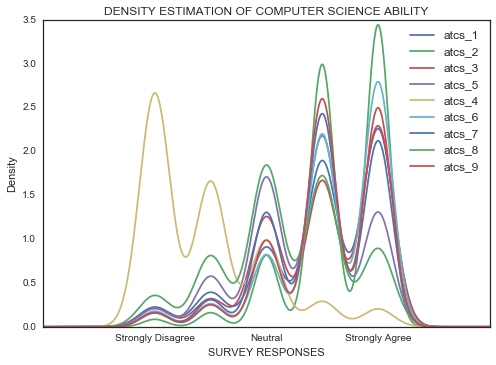

In [11]:
dataset[atcs].plot(kind='kde');
x = [-0.5, 0.0, 0.5, 1.0, 1.5]
labels = ["", "Strongly Disagree", "Neutral", "Strongly Agree" , ""]
pyplt.xticks(x, labels)

pyplt.xlabel('SURVEY RESPONSES')
pyplt.title('DENSITY ESTIMATION OF COMPUTER SCIENCE ABILITY')
pyplt.legend(loc='upper right', shadow=True, fontsize='medium')
pyplt.savefig('report/figures/atcs.png', dpi=100)

#### Computer Science beliefs
- atcs_1 I like to use computer science to solve problems.
- atcs_2 I can learn to understand computing concepts.
- atcs_3 I can achieve good grades (C or better) in computing courses.
- atcs_4 I do not like using computer science to solve problems.
- atcs_5 I am confident that I can solve problems by using computation.
- atcs_6 The challenge of solving problems using computer science appeals to me.
- atcs_7 I am comfortable with learning computing concepts.
- atcs_8 I am confident about my abilities with regards to computer science.
- atcs_9 I do think I can learn to understand computing concepts.

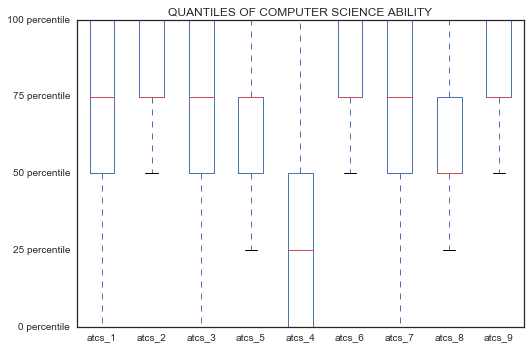

In [12]:
dataset[atcs].plot.box();
y = np.arange(0,1.1,0.25)
labels = ['{} percentile'.format(int(i*100)) for i in y]
pyplt.yticks(y, labels)

pyplt.title('QUANTILES OF COMPUTER SCIENCE ABILITY')
pyplt.savefig('report/figures/atcs_quantile.png', dpi=200)

So what does the boxplot of `atcs_dimension` tell us about the data? From the generated figure, we can see that the **median** of this dimension is approximately at the 75 percentile, which based on our Likert scale dataset means most students generally agree with the mostly positive attitudinal questions asked about their CS beliefs. Attitudes about computational thinking also have a similar pattern.

#### Computational thinking beliefs
- atct_1 I am good at solving a problem by thinking about similar problems I have solved before.
- atct_2 I have good research skills.
- atct_3 I am good at using online search tools.
- atct_4 I am persistent at solving puzzles or logic problems.
- atct_5 I know how to write computer programs.
- atct_6 I am good at building things.
- atct_7 I am good at ignoring irrelevant details to solve a problem.
- atct_8 I know how to write a computer program to solve a problem.

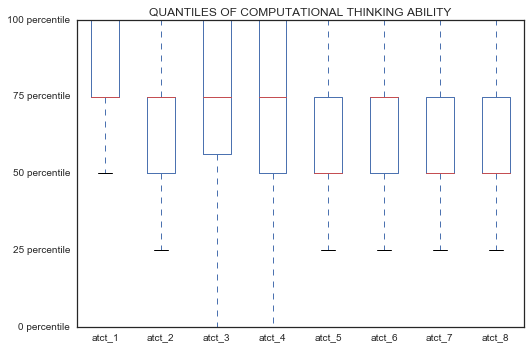

In [13]:
dataset[atct].plot.box();
y = np.arange(0,1.1,0.25)
labels = ['{} percentile'.format(int(i*100)) for i in y]
pyplt.yticks(y, labels)

pyplt.title('QUANTILES OF COMPUTATIONAL THINKING ABILITY')
pyplt.savefig('report/figures/atct_quantile.png', dpi=300)

#### Beliefs about Belonging 
- blg_1 In this class, I feel I belong.
- blg_2 In this class, I feel awkward and out of place.
- blg_3 In this class, I feel like my ideas count.
- blg_4 In this class, I feel like I matter.

When it comes to belonging we see a different pattern. Majority of students feel like the belong, but most of them are *neutral* when belonging becomes more specific.

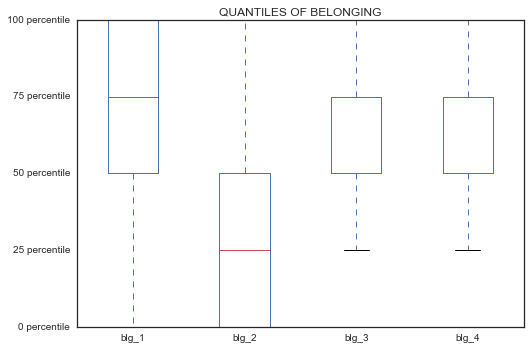

In [14]:
dataset[blg].plot.box();
y = np.arange(0,1.1,0.25)
labels = ['{} percentile'.format(int(i*100)) for i in y]
pyplt.yticks(y, labels)

pyplt.title('QUANTILES OF BELONGING')
pyplt.savefig('report/figures/blg_quantile.png', dpi=100)

#### Gendered notions of intelligence
- atcsgender_1 Women are less capable of success in CS than men.
- atcsgender_2 Women are smarter than men.
- atcsgender_3 Men have better math and science abilities than women.

From a plot of its density estimation, I can see that the distribution for this dimension is really skewed to the right, i.e., most students *strongly disagree* with the statements. That does not come as a suprise, what I found fascinating is that the median for `atcsgender_2` is at the 25 percentile, which corresponds to *neutral.* You can see this in the boxplot. While students do not agree that women are smarter than men, half of them is undecided about this statement!



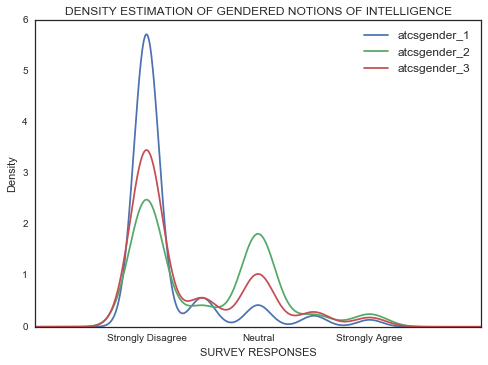

In [15]:
dataset[atcsgender].plot(kind='kde');
x = [-0.5, 0.0, 0.5, 1.0, 1.5]
labels = ["", "Strongly Disagree", "Neutral", "Strongly Agree" , ""]
pyplt.xticks(x, labels)

pyplt.xlabel('SURVEY RESPONSES')
pyplt.title('DENSITY ESTIMATION OF GENDERED NOTIONS OF INTELLIGENCE')
pyplt.legend(loc='upper right', shadow=True, fontsize='medium')
pyplt.savefig('report/figures/atcsgender.png', dpi=100)

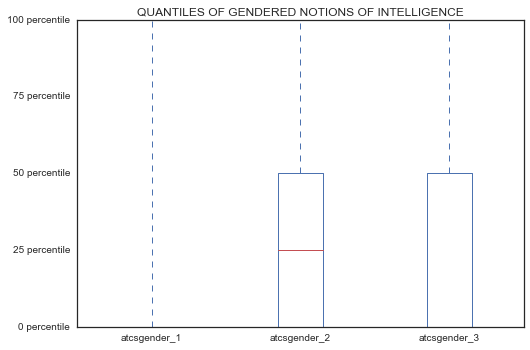

In [16]:
dataset[atcsgender].plot.box();
y = np.arange(0,1.1,0.25)
labels = ['{} percentile'.format(int(i*100)) for i in y]
pyplt.yticks(y, labels)

pyplt.title('QUANTILES OF GENDERED NOTIONS OF INTELLIGENCE')
pyplt.savefig('report/figures/atcsgender_quantile.png', dpi=100)

### Extract features and labels 

Extract feature (X) and target (y) columns

In [17]:
target_col = dataset['gender_Female']  #  column is the target/label 
y = target_col  # corresponding targets/labels

print "\nLabel values:-"
print y.head()  


Label values:-
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: gender_Female, dtype: float64


In [18]:
X = dataset.drop(['gender_Female', 'gender_Male'], axis=1, inplace=False)

print "\nFeature values:-"
print X.head()  


Feature values:-
   atcs_1  atcs_2  atcs_3  atcs_4  atcs_5  atcs_6  atcs_7  atcs_8  atcs_9  \
0     0.5    0.75    1.00    0.50    0.75    0.75    0.75    0.50    0.75   
1     0.0    0.00    0.00    1.00    0.00    0.00    0.00    0.00    0.25   
2     1.0    1.00    1.00    0.00    1.00    1.00    1.00    1.00    1.00   
3     1.0    0.75    0.75    0.00    0.75    0.75    0.75    1.00    1.00   
4     0.5    0.50    0.75    0.25    0.50    0.75    1.00    0.25    0.75   

   atcsgender_1         ...          mtr_3  prcs_1  prcs_2  prcs_3  prcs_4  \
0           0.0         ...            0.0     0.0     0.0     0.0     0.0   
1           0.0         ...            0.0     0.0     0.0     1.0     1.0   
2           0.0         ...            1.0     0.0     0.0     0.0     0.0   
3           0.0         ...            0.0     0.0     0.0     0.0     0.0   
4           0.0         ...            0.0     0.0     0.0     0.0     0.0   

   prcs_5  prepared  priorcs10  reason_class_Inter

### Determine if classes are balanced
- As we can see the dataset is unbalanced, we have more males than females.




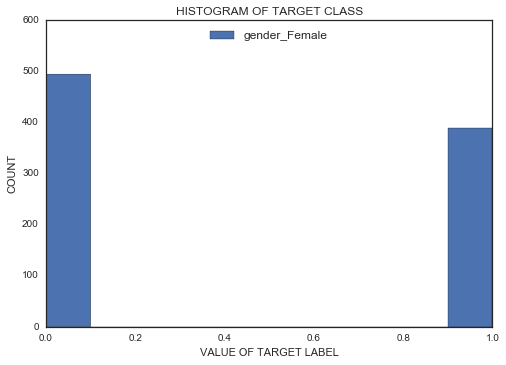

In [19]:
y.plot.hist()

pyplt.grid(False)
_= pyplt.xlabel('VALUE OF TARGET LABEL')
_= pyplt.ylabel('COUNT')
_= pyplt.title('HISTOGRAM OF TARGET CLASS')
_= pyplt.legend(loc='upper center', shadow=True, fontsize='medium')
_= pyplt.yticks(np.arange(0, 700, 100))
pyplt.savefig('report/figures/targetClass.png', dpi=100)


In [20]:
num_male = y.tolist().count(0)
num_female = y.tolist().count(1)


print "number of males in data", num_male
print "number of females in data", num_female


print "ration of males to females {}".format(num_male/ num_female)


number of males in data 494
number of females in data 388
ration of males to females 1.27319587629


In [21]:
# First, decide how many training vs test samples you want
num_all = X.shape[0]  # same as len(student_data)
num_train = 662  # about 75% of the data
num_test = num_all - num_train

In [22]:
from sklearn import cross_validation



def shuffle_split_data(X, y):
    """ Shuffles and splits data into 75% training and 25% testing subsets,
        then returns the training and testing subsets. """
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, 
                                                                        train_size=num_train, random_state=42)
    
    
    


    # Return the training and testing data subsets
    return X_train, y_train, X_test, y_test

In [23]:
try:
    X_train, y_train, X_test, y_test = shuffle_split_data(X, y)
    print "Successfully shuffled and split the data!"
except:
    print "Something went wrong with shuffling and splitting the data."


print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])


Successfully shuffled and split the data!
Training set: 662 samples
Test set: 220 samples


## Modeling and Validating

### Algorithms and Techniques

For the problem of determining the factors that predict intro CS experience based on gender, I experimented with four different classifiers, a decision tree classifier, two ensemble methods and a support vector machine:

- I selected a Random Forest classifier because it is considered one of the best off-the-shelf learning algorithm, and requires almost no tuning. 

- I selected an eXtreme Gradient Boosted (XGBoost) trees classifier; which is an advanced implementation of the gradient boosting algorithm. From reading literature on machine learning in practice, the XGBoost classifier has differentiated itself as a classifier that has successfully demonstrated its performance in a wide range of problems. For example, "among the 29 challenge winning solutions published at Kaggle's blog during 2015, 17 solutions used XGBoost."

- I selected a Support Vector Machine (SVMs) because they are very robust classifiers and *more importantly*, they have a method to correct for class imbalances. 
              
- Finally I selected a Decision Tree classifier because it lends itself to interpretability. For this problem domain, it is not just satisfactory for me to discriminate between male and female students, what I ultimately want is to gain *insights* into what the salient factors around the experience of intro CS are, based on gender.


In [24]:
X = X_train

seed = 342 # For reproducability
folds = 50

In [25]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn import metrics


models = {
          'XGBoost': XGBClassifier(),
          'DecisionTree': DecisionTreeClassifier(),
          'SVC': svm.SVC(),
          'RandomForest': RandomForestClassifier()
         }


In [45]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_train, n_folds=folds, random_state=np.random.seed(seed))
    results = cross_val_score(model, X, y_train, cv=kfold, scoring='f1')
    print("Training data score: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'
    
   

RandomForest
Training data score: 46.79% (20.99%) 

DecisionTree
Training data score: 51.15% (17.82%) 

XGBoost
Training data score: 57.61% (19.07%) 

SVC
Training data score: 54.63% (18.55%) 



### Predict 

RandomForest
F1 score: 58.10%


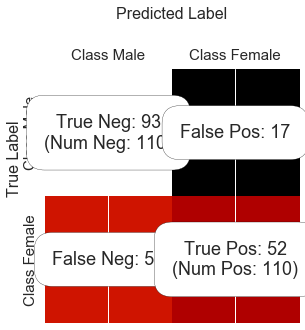

DecisionTree
F1 score: 58.82%


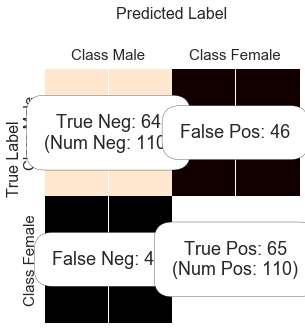

XGBoost
F1 score: 68.37%


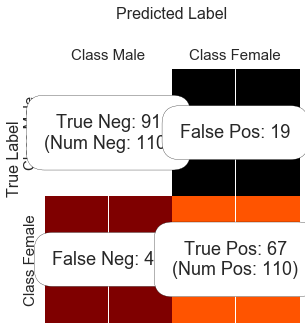

SVC
F1 score: 54.12%


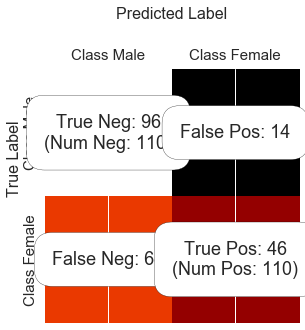

In [44]:
Features_test = X_test

for model_name, model in models.iteritems():
    print model_name
    # make predictions for test data
    model.fit(X, y_train)
    y_pred = model.predict(Features_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    
    print "F1 score: %.2f%%"% (metrics.f1_score(y_test, predictions) * 100)
    
    C = confusion_matrix(y_test, predictions)
    tools.show_confusion_matrix(C, 'report/figures/'+model_name+'.png', ['Class Male', 'Class Female'])

### Select XGBoost classifier

From running these baseline classifiers, I selected the xgboost classifier because it had the highest score. In addition, when I looked at the result of the confusion matrix, I decided to use the lowest **false negative** count for the female class as my evaluation metric. From the images, the *Decision Tree* and the *XGBoost*, I can see that the decision tree and xgboost learners are tied for having the lowest score of false negatives for the female class.

### Feature Importance
There are two things that need consideration when using xgBoost for understanding feature importance: the features that are doing the *most* work in splitting the data, and the automatically generated feature importance ranking that is done in xgBoost.

I plotted some estimators in the xgboost learners to see which features are doing the most work in splitting the data. I chose to focus on the **first** and **second** tree in the ensemble. On simple models, the first two trees may be enough to gain a *strong* understanding.



In [28]:
model = XGBClassifier()
model.fit(X, y_train)
g = xgb.to_graphviz(model, num_trees=1, rankdir='LR')
g.format = 'png'
g.render('report/figures/firstXGraph', view=False)
g = xgb.to_graphviz(model, num_trees=2, rankdir='LR')
g.format = 'png'
g.render('report/figures/SecondXGraph', view=False)

'report/figures/SecondXGraph.png'

### First tree in the ensemble
![first tree in ensemble](report/figures/firstXGraph.png)

### Second tree in the ensemble
![second tree in ensemble](report/figures/secondXGraph.png)

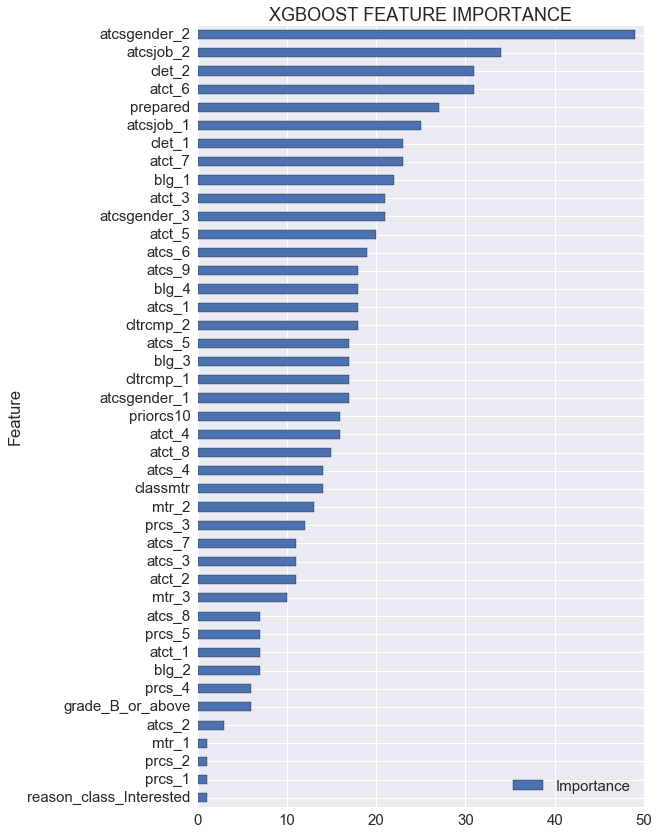

In [29]:
sns.set(font_scale = 1.5)

importances = model.booster().get_fscore()
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,14));
pyplt.title('XGBOOST FEATURE IMPORTANCE')
pyplt.savefig('report/figures/featureImportance.png', dpi=200, bbox_inches='tight')


|Coded item|Description|
|---|---|
|atcsgender_2|Women are smarter than men.|
|atcsjobs_2|My career goals do not require that I learn computing skills. |
|clet_2|I think about the ethical, legal, and social implications of computing.|
|atct_6|I am good at building things.|
|prepared|How prepared did you feel about this class before it started?|
|atcsjob_1|Knowledge of computing will allow me to secure a good job.|
|clet_1|I work well in teams.|
|atct_7|I am good at ignoring irrelevant details to solve a problem.|
|blg_1|In this class, I feel I belong.|
|atct_3|I am good at using online search tools.|


# Tune Estimator

### Ideal choices of parameters as taken from Xgboost With Python ebook

- Number of Trees (`n_estimators`) set to a fixed value between 100 and 1000, depending on the dataset size.
- Learning Rate (`learnin_rate`) simplified to the ratio: [2 to 10]/trees, depending on the trees number of trees.
- Row Sampling (`subsample`) grid searched values in the range [0.5, 0.75, 1.0].
- Column Sampling (`colsample` bytree and maybe colsample bylevel) grid searched values in the range [0.4, 0.6, 0.8, 1.0].
- Min Leaf Weight (`min_child_weight`) simplified to the ratio 3/rare_events , where rare events rare events is the percentage of rare event observations in the dataset.
- Tree Size (`max_depth`) grid searched values in the rage [4, 6, 8, 10].
- Min Split Gain (`gamma`) fixed with a value of zero.


In [30]:
X = X_train

In [31]:
from sklearn.grid_search import GridSearchCV



# Build a stratified shuffle object because of unbalanced data
folds = 50
ssscv = StratifiedShuffleSplit(y_train, folds, random_state=np.random.seed(seed))

params_grid = {
            'learning_rate': [0.2222, 0.4444, 0.6666, 0.8888],
            'max_depth': [4, 6, 8, 10],
            'n_estimators': range(100, 1100, 100),
            'colsample_bytree': [0.6],
            'subsample':[0.7]
}

params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

In [32]:
# Load and use already tuned classifier, else tune classifier

tune_flag = False

if tune_flag:
    grid = GridSearchCV(estimator=XGBClassifier(**params_fixed),
        param_grid=params_grid,
        cv=ssscv,
        scoring='f1')
    grid.fit(X, y_train)
    
    print "Best accuracy obtained: {0}".format(grid.best_score_)
    print "Parameters:"
    for key, value in grid.best_params_.items():
        print "\t{}: {}".format(key, value)
    model = grid.best_estimator_
    
    # save model to file
    pickle.dump(model, open("genderedCSExperience.pickle.dat", "wb"))
    
else:    
    model = tools.load_model()
    print model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.2222, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.7)


In [33]:
Features_test = X_test

# make predictions for test data
model.fit(X, y_train)
y_pred = model.predict(Features_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
print "F1 score: %.2f%%"% (f1_score(y_test, predictions) * 100)

F1 score: 75.00%


In [34]:
model.fit(X, y_train)
g = xgb.to_graphviz(model, num_trees=20, rankdir='TB')
g.format = 'png'
g.render('report/figures/Tuned_model_graph', view=False)

'report/figures/Tuned_model_graph.png'

![tuned tree](report/figures/Tuned_model_graph.png)

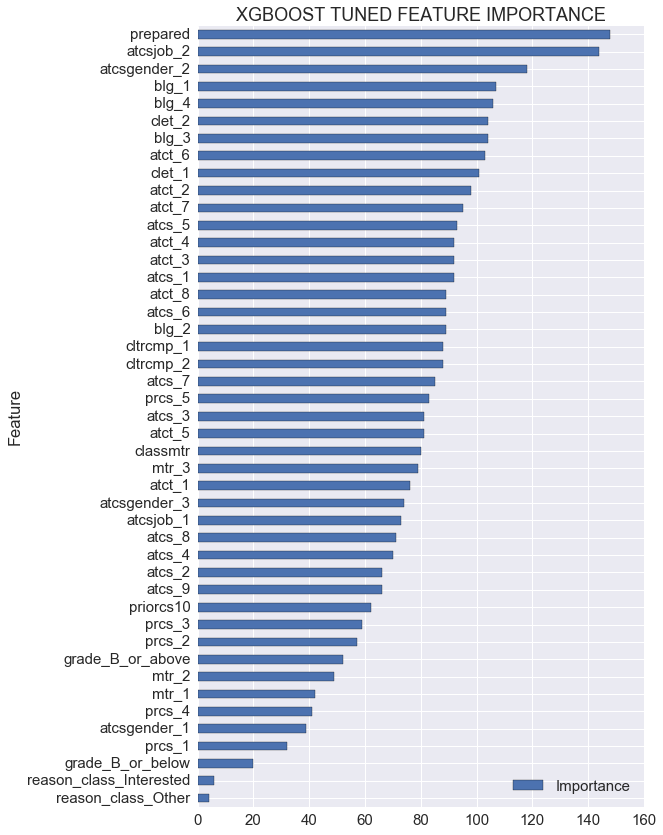

In [35]:
importances = model.booster().get_fscore()
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,14));
pyplt.title('XGBOOST TUNED FEATURE IMPORTANCE')
pyplt.savefig('report/figures/tunedfeatureImportance.png', dpi=200, bbox_inches='tight')


### Information-Gain-based Feature Ranking 

In [66]:
tools.create_feature_map(list(importances.keys()),'feature_map_file_name.txt')

In [67]:
params_dict = dict(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.2222, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.7)

In [68]:
import xgboost as xgb

xgdmat = xgb.DMatrix(X, y_train) # Create our DMatrix to make XGBoost more efficient
cv_xgb = xgb.cv(params = params_dict, dtrain = xgdmat, num_boost_round = 3000, nfold = 50,
                metrics =['error'],
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

Will train until cv error hasn't decreased in 100 rounds.
Stopping. Best iteration: 161


In [69]:
bst = xgb.train(params_dict, xgdmat, num_boost_round = 161)

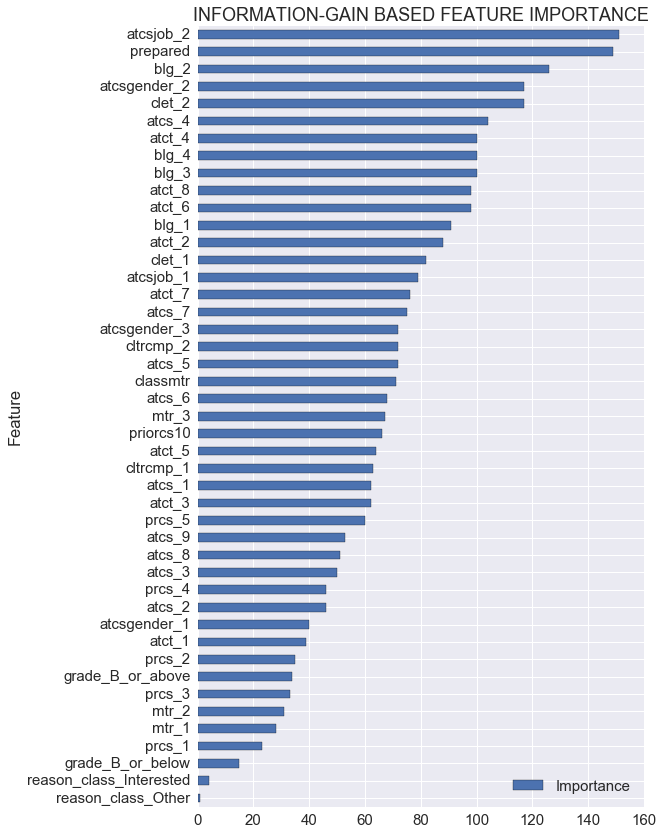

In [70]:
importances = bst.get_fscore()
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,14));
pyplt.title('INFORMATION-GAIN BASED FEATURE IMPORTANCE')
pyplt.savefig('report/figures/inforgainfeatureImportance.png', dpi=200, bbox_inches='tight')


In [71]:
bst.dump_model('xgb_model_txt_name.txt', with_stats = True)

In [ ]:
sns.set(font_scale = 1)

C = confusion_matrix(y_test, predictions)
tools.show_confusion_matrix(C, 'report/figures/tuned_model_CM.png', ['Class Male', 'Class Female'])